## SVM Máquina de vetores de suporte (Support vector machine) no Dólar Futuro
 

#### Etapas

- Passo 0 - Assitir às aulas anteriores de SVM
- Passo 1 - Carregar as bibliotecas
- Passo 2 - Carregar a base de dados
- Passo 3 - Tratamento dos dados
- Passo 4 - Construçao dos alvos e variaveis
- Passo 5 - Preparaçao da base para treinamento e teste
- Passo 6 - Treinamento do modelo
- Passo 7 - Avaliaçao dos Resultados
- Passo 8 - Otimizaçao com Grid Search
- Passo 9 - Treinamento com o modelo otimizado
- Passo 10 - Ensemble simples

Uma máquina de vetores de suporte é um conceito na ciência da computação para um conjunto de métodos de aprendizado supervisionado que analisam os dados e reconhecem padrões, usado para classificação e análise de regressão.

________________________________________________________


### Passo 1 - Carregar as bibliotecas

In [6]:
# Carregando as bibliotecas

import time
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    accuracy_score,
    precision_recall_curve,
    auc,
    make_scorer,
    recall_score,
)
from sklearn import svm

# statsmodels is not used in the provided code, so it's removed

import pandas as pd
import numpy as np


In [7]:
# Para remover os warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

______________________________________________________

### Passo 2 - Carregar a base de dados

In [14]:
# Carregando a base de dados e fazendo os checks iniciais

# Muda o diretorio de trabalho
import os
os.chdir("C:\\Workspace\\ml-diogo-school\\data")

df1 = pd.read_csv("WDOFUT.csv", sep = ";")

df1.shape[0]

3854

In [15]:
df1.head()

,Data,Abertura,Maxima,Minima,Fechamento
0,17/05/2005,2487.0,2502.0,2487.0,2494.0
1,18/05/2005,2484.0,2484.0,2469.0,2470.0
2,19/05/2005,2455.0,2458.0,2450.0,2455.0
3,20/05/2005,2460.0,2463.0,2451.0,2451.0
4,23/05/2005,2443.0,2443.0,2432.0,2433.0


______________________________________________________

### Passo 3 - Tratamento dos dados

In [16]:
# Ajustando a data - precisamos transforma-la nos indices do data frame

df1["Data"] = pd.to_datetime(df1["Data"]).dt.normalize()

df1 = df1.set_index("Data")

In [17]:
df1.head()

,Abertura,Maxima,Minima,Fechamento
Data,,,,
2005-05-17,2487.0,2502.0,2487.0,2494.0
2005-05-18,2484.0,2484.0,2469.0,2470.0
2005-05-19,2455.0,2458.0,2450.0,2455.0
2005-05-20,2460.0,2463.0,2451.0,2451.0
2005-05-23,2443.0,2443.0,2432.0,2433.0


In [18]:
df1.describe()

,Abertura,Maxima,Minima,Fechamento
count,3854.000000,3854.000000,3854.000000,3854.000000
mean,2695.424453,2714.421069,2677.683342,2695.850519
std,996.551114,1006.839596,986.645656,997.148535
min,1534.500000,1542.000000,1530.000000,1541.500000
25%,1910.000000,1921.375000,1896.250000,1909.125000
50%,2275.500000,2292.750000,2260.000000,2274.750000
75%,3312.125000,3333.000000,3292.750000,3313.750000
max,5927.500000,5977.500000,5823.500000,5894.500000


______________________________________________________

### Passo 4 - Construçao dos alvos e variaveis

In [19]:
# Construcao dos alvos - Vamos trabalhar com um horizonte mais longo, de 5 periodos?

periodos = 1

# lag de X periodos
df1["Lag1"] = df1["Fechamento"].shift(-periodos)

# Alvo 1 - Retorno
df1["Retorno"] = df1["Fechamento"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variaçao em Pontos do alvo
df1["Pontos"] = (df1["Fechamento"] - df1["Fechamento"].shift(1))
df1["Pontos"] = df1["Pontos"].shift(-periodos)

In [20]:
df1["Retorno"].describe()

count    3853.000000
mean        0.000246
std         0.011053
min        -0.079897
25%        -0.005851
50%         0.000000
75%         0.005831
max         0.078145
Name: Retorno, dtype: float64

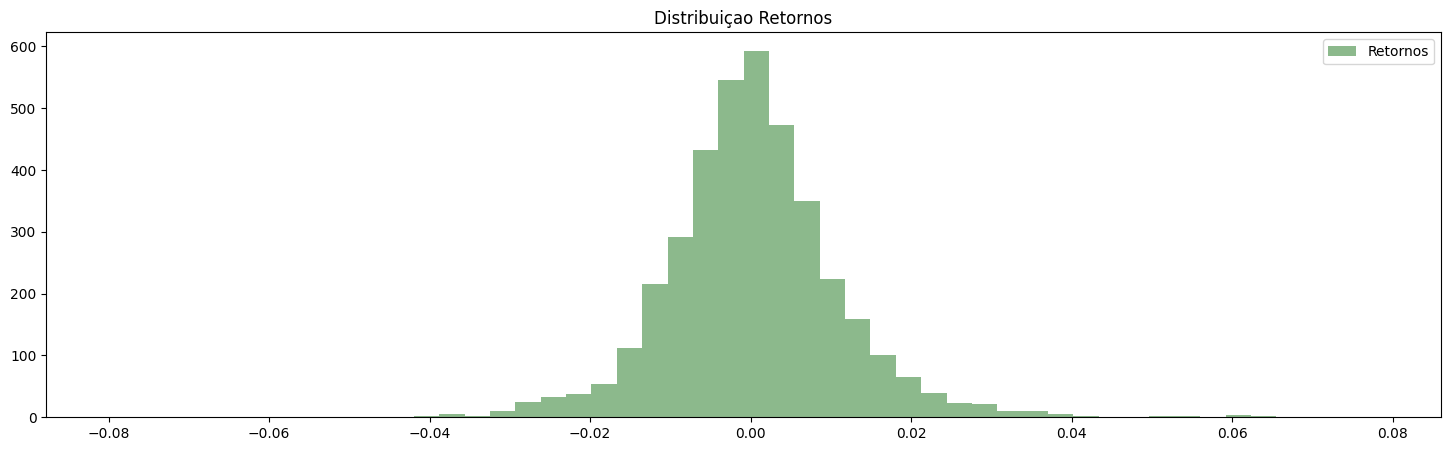

In [21]:
plt.figure(figsize = (18,5))
plt.hist(df1["Retorno"], bins = 50
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [22]:
# Criacao do alvo
df1["Alvo_Bin"] = np.where(df1['Alvo1'] > df1["Retorno"].describe()[6]/2 , 1
                           , np.where(df1['Alvo1'] < df1["Retorno"].describe()[4]/2, -1, 0))

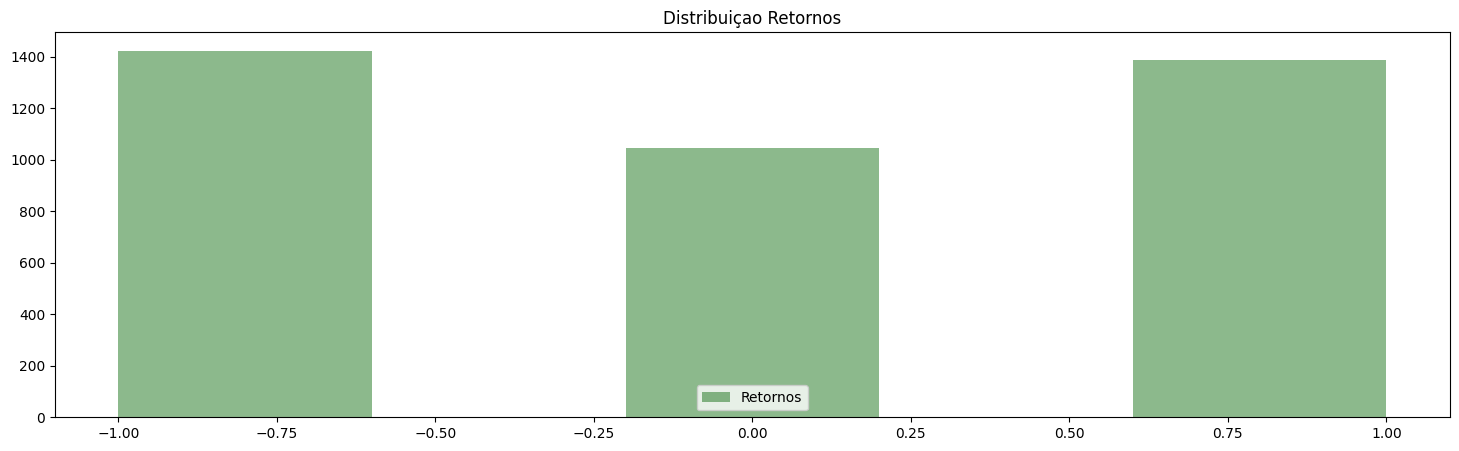

In [23]:
plt.figure(figsize = (18,5))
plt.hist(df1["Alvo_Bin"], bins = 5
        , alpha = 0.45
        , histtype = "stepfilled"
        , color = "darkgreen"
        , edgecolor = "none"
        , label = "Retornos");

plt.legend()
plt.title("Distribuiçao Retornos");

In [24]:
# Construçao das Variaveis

# Desvio Padrao de 5 dias
df1["std5"] = df1["Retorno"].rolling(5).std()

# Desvio Padrao de 10 dias
df1["std10"] = df1["Retorno"].rolling(10).std()

# Desvio Padrao de 15 dias
df1["std15"] = df1["Retorno"].rolling(15).std()

# Proporçao do corpo do candle em relacao ao range do dia
df1["prop"] = (df1["Fechamento"]-df1["Abertura"])/(df1["Maxima"]-df1["Minima"])

# Direçao do dia atual
df1["dir_D"] = np.where(df1['Fechamento'] > df1['Abertura'] , '1', '0')

# Direçao D-1
df1["dir_D-1"] = df1["dir_D"].shift(1)

# Direçao D-2
df1["dir_D-2"] = df1["dir_D"].shift(2)

# Direçao D-3
df1["dir_D-3"] = df1["dir_D"].shift(3)

# Media Movel de 15 dias std5
df1["mm_std5"] = df1["std5"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std10"] = df1["std10"].rolling(15).mean()

# Media Movel de 15 dias std5
df1["mm_std15"] = df1["std15"].rolling(15).mean()

# RSL std5
df1["RSL_std5"] = (df1["std5"]/df1["std5"].rolling(15).mean())-1

# RSL std10
df1["RSL_std10"] = (df1["std10"]/df1["std10"].rolling(15).mean())-1

# RSL std15
df1["RSL_std15"] = (df1["std15"]/df1["std15"].rolling(15).mean())-1

# Aplicando a fisica

p = 5 

# Velocidade de p dias
df1["v"] = (df1["Retorno"] - df1["Retorno"].shift(p))/p

# Aceleraçao de p dias
df1["a"] = (df1["v"] - df1["v"].shift(p))/p

# Força
# Calculando a massa
df1["m"] = df1["Retorno"].rolling(p).sum()
df1["f"] = df1["m"]*df1["a"]

# Energia cinética
df1["T"] = 0.5*df1["m"]*df1["v"]*df1["v"]


# Trabalho 
# cateto_oposto
cat_op = df1["Retorno"].rolling(p).sum()-df1["Retorno"].rolling(1).sum()
cat_ad = p
df1["cat"] = cat_op/cat_ad
df1 = df1.dropna(axis = 0)
df1["w"] = df1["f"]*np.cos(np.arctan(df1["cat"]))

# Energia potencial
df1["k"] = cat_op*df1["m"]

# Torque
df1["tau"] = df1["f"]*np.sin(np.arctan(df1["cat"]))

# Momentum
df1["M"] = df1["m"]*df1["v"]

# Gravidade
df1["g"] = df1["m"]*df1["Retorno"].rolling(p).sum()/(df1["m"]/df1["Retorno"].rolling(p).sum())*(df1["m"]/df1["Retorno"].rolling(p).sum())

df1.head(10)

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,std5,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2005-06-28,2369.0,2375.0,2369.0,2374.0,2360.0,-0.002940,-0.005897,-14.0,-1,0.007640,...,0.000274,-0.004085,-1.119103e-06,-3.144358e-09,-0.000229,-1.119103e-06,0.000005,2.562563e-10,-0.000005,NaN
2005-06-29,2365.0,2365.0,2350.0,2360.0,2350.5,-0.005897,-0.004025,-9.5,-1,0.007206,...,-0.000768,-0.014596,1.121397e-05,-3.225396e-08,-0.001740,1.121395e-05,0.000127,-1.950994e-08,0.000031,NaN
2005-06-30,2346.0,2356.0,2346.0,2350.5,2371.0,-0.004025,0.008722,20.5,1,0.003145,...,-0.001223,-0.027390,3.350148e-05,-8.966265e-08,-0.004673,3.350111e-05,0.000640,-1.565469e-07,0.000070,NaN
2005-07-01,2357.0,2382.0,2357.0,2371.0,2392.0,0.008722,0.008857,21.0,1,0.005860,...,0.000912,-0.007907,-7.211111e-06,-6.002671e-08,-0.003326,-7.211071e-06,0.000131,2.398154e-08,-0.000031,NaN
2005-07-04,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,0.007240,...,0.000756,0.004716,3.563098e-06,1.502823e-08,-0.000828,3.563097e-06,-0.000020,-2.950982e-09,0.000012,0.000022
2005-07-05,2400.0,2404.0,2384.0,2404.0,2415.0,0.005017,0.004576,11.0,1,0.007045,...,0.000070,0.012673,8.885036e-07,1.604573e-08,0.001531,8.885026e-07,0.000097,1.360462e-09,0.000020,0.000161
2005-07-06,2406.0,2422.0,2406.0,2415.0,2396.0,0.004576,-0.007867,-19.0,-1,0.005236,...,0.000839,0.023146,1.942769e-05,5.077316e-08,0.003714,1.942756e-05,0.000430,7.215345e-08,0.000048,0.000536
2005-07-07,2426.0,2427.0,2396.0,2396.0,2388.0,-0.007867,-0.003339,-8.0,-1,0.006855,...,0.000358,0.019304,6.911906e-06,5.698978e-09,0.005434,6.911804e-06,0.000524,3.756012e-08,-0.000015,0.000373
2005-07-08,2406.0,2406.0,2379.0,2388.0,2359.0,-0.003339,-0.012144,-29.0,-1,0.006839,...,-0.001262,0.007243,-9.138882e-06,2.107069e-08,0.002116,-9.138861e-06,0.000077,-1.934141e-08,-0.000017,0.000052


In [25]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0) 

df1_filtrado= df1_filtrado.drop(["std5","std10","std15","mm_std5","mm_std10","mm_std15"], axis = 1)

In [26]:
corte = 10

df1_filtrado["RSL_std5"] = pd.qcut(df1_filtrado["RSL_std5"], corte, labels = False)
df1_filtrado["RSL_std10"] = pd.qcut(df1_filtrado["RSL_std10"], corte, labels = False)
df1_filtrado["RSL_std15"] = pd.qcut(df1_filtrado["RSL_std15"], corte, labels = False)
df1_filtrado["v"] = pd.qcut(df1_filtrado["v"], corte, labels = False)
df1_filtrado["a"] = pd.qcut(df1_filtrado["a"], corte, labels = False)
df1_filtrado["m"] = pd.qcut(df1_filtrado["m"], corte, labels = False)
df1_filtrado["f"] = pd.qcut(df1_filtrado["f"], corte, labels = False)
df1_filtrado["T"] = pd.qcut(df1_filtrado["T"], corte, labels = False)
df1_filtrado["w"] = pd.qcut(df1_filtrado["w"], corte, labels = False)
df1_filtrado["k"] = pd.qcut(df1_filtrado["k"], corte, labels = False)
df1_filtrado["tau"] = pd.qcut(df1_filtrado["tau"], corte, labels = False)
df1_filtrado["M"] = pd.qcut(df1_filtrado["M"], corte, labels = False)
df1_filtrado["g"] = pd.qcut(df1_filtrado["g"], corte, labels = False)

In [27]:
pd.crosstab(pd.qcut(df1["RSL_std5"], corte, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std5,,,
0,3.294979,2.955021,3.765690
1,3.817992,2.771967,3.399582
2,4.184100,2.588912,3.216527
3,3.713389,2.641213,3.661088
4,3.817992,2.693515,3.478033
5,3.687238,2.536611,3.765690
6,3.347280,2.981172,3.687238
7,3.713389,2.981172,3.294979
8,3.530335,2.641213,3.817992


In [28]:
pd.crosstab(pd.qcut(df1["RSL_std5"], 5, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100

Alvo_Bin,-1,0,1
RSL_std5,,,
0,7.112971,5.726987,7.165272
1,7.897490,5.230126,6.877615
2,7.505230,5.230126,7.243724
3,7.060669,5.962343,6.982218
4,7.217573,4.994770,7.792887


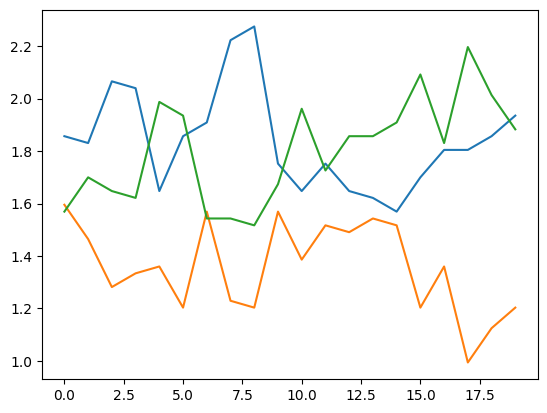

In [29]:
plt.plot(pd.crosstab(pd.qcut(df1["RSL_std10"], 20, labels = False), df1["Alvo_Bin"])/df1.shape[0]*100);

In [30]:
df1_filtrado.tail()

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,prop,...,a,m,f,T,cat,w,k,tau,M,g
Data,,,,,,,,,,,,,,,,,,,,,
2020-12-08,5121.5,5139.5,5063.0,5120.0,5172.5,0.004020,0.010254,52.5,1,-0.019608,...,9,1,0,0,-0.004200,0,7,9,0,6
2020-12-09,5100.5,5198.0,5087.0,5172.5,5027.5,0.010254,-0.028033,-145.0,-1,0.648649,...,4,3,5,2,-0.003837,5,5,2,1,3
2020-12-10,5112.0,5133.0,5016.0,5027.5,5070.5,-0.028033,0.008553,43.0,1,-0.722222,...,5,1,3,0,0.000762,3,0,4,8,7
2020-12-11,5055.0,5089.0,5029.5,5070.5,5117.5,0.008553,0.009269,47.0,1,0.260504,...,6,1,1,2,-0.005058,1,7,8,1,6
2020-12-14,5039.0,5131.0,5010.5,5117.5,5089.5,0.009269,-0.005471,-28.0,-1,0.651452,...,8,5,6,8,-0.001041,6,0,3,6,1


In [31]:
df1_filtrado.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag1', 'Retorno',
       'Alvo1', 'Pontos', 'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'm', 'f',
       'T', 'cat', 'w', 'k', 'tau', 'M', 'g'],
      dtype='object')

In [32]:
df1_filtrado = df1_filtrado.drop(["m","cat","M"], axis=1)

______________________________________________________

### Passo 5 - Preparaçao da base para treinamento e teste

In [33]:
# Separando os dados entre treinamento e teste

# Vamos treinar o modelo de 2005 à 2012
start_train = "2005-08-07"
end_train = "2012-12-31"

# Vamos testar o modelo de 2013 à 2020
start_test = "2013-01-01"
end_test = "2020-12-08"

df1_train1 = df1_filtrado.loc[start_train : end_train]

df1_test1 = df1_filtrado.loc[start_test : end_test]

In [34]:
df1_filtrado3 = df1_filtrado.copy()
df1_filtrado4 = df1_filtrado.copy()

In [35]:
df1_test1.head()

,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,prop,...,RSL_std10,RSL_std15,v,a,f,T,w,k,tau,g
Data,,,,,,,,,,,,,,,,,,,,,
2013-01-02,2041.0,2056.5,2041.0,2055.5,2057.0,-0.001700,0.000730,1.5,0,0.935484,...,3,0,4,6,2,4,2,3,6,3
2013-01-03,2057.0,2059.5,2043.5,2057.0,2043.5,0.000730,-0.006563,-13.5,-1,0.000000,...,4,0,3,3,6,3,6,5,2,4
2013-01-04,2057.5,2059.0,2041.0,2043.5,2039.0,-0.006563,-0.002202,-4.5,0,-0.777778,...,3,1,7,8,2,3,2,0,3,1
2013-01-07,2044.0,2045.5,2033.0,2039.0,2050.0,-0.002202,0.005395,11.0,1,-0.400000,...,3,1,5,4,4,4,4,1,4,1
2013-01-08,2036.5,2050.0,2029.5,2050.0,2050.0,0.005395,0.000000,0.0,0,0.658537,...,4,2,4,2,6,4,6,3,2,2


In [36]:
df1_filtrado.columns

Index(['Abertura', 'Maxima', 'Minima', 'Fechamento', 'Lag1', 'Retorno',
       'Alvo1', 'Pontos', 'Alvo_Bin', 'prop', 'dir_D', 'dir_D-1', 'dir_D-2',
       'dir_D-3', 'RSL_std5', 'RSL_std10', 'RSL_std15', 'v', 'a', 'f', 'T',
       'w', 'k', 'tau', 'g'],
      dtype='object')

In [37]:
# Separando os dados com as variaveis em x e o alvo em y
 
x_train1 = df1_train1.iloc[:, 9:24]
y_train1 = df1_train1['Alvo_Bin'].values.reshape(-1, 1)

x_test1 = df1_test1.iloc[:, 9:24]
y_test1 = df1_test1['Alvo_Bin'].values.reshape(-1, 1)

______________________________________________________

### Passo 6 - Treinamento do modelo

In [38]:
# Treinando o modelo

# Kernels: rbf, poly, linear

svm1 = svm.SVC(kernel = "rbf", max_iter = 2000, gamma = "auto", random_state = 42)

svm1.fit(x_train1, y_train1)# essa é a linha que treina o modelo!!!!

SVC(gamma='auto', max_iter=2000, random_state=42)

In [39]:
# Prediçoes para o treinamento e teste

y_pred_train1 = svm1.predict(x_train1)
y_pred_test1 = svm1.predict(x_test1)

______________________________________________________

### Passo 7 - Avaliaçao dos Resultados

In [40]:
# Treinamento

print(confusion_matrix(y_train1, y_pred_train1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train1, y_pred_train1))

[[570  67  42]
 [124 379  45]
 [113  70 416]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.71      0.84      0.77       679
           0       0.73      0.69      0.71       548
           1       0.83      0.69      0.75       599

    accuracy                           0.75      1826
   macro avg       0.76      0.74      0.74      1826
weighted avg       0.75      0.75      0.75      1826



In [41]:
# Teste

print(confusion_matrix(y_test1, y_pred_test1))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test1))

[[364 154 195]
 [234 125 128]
 [343 172 250]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.39      0.51      0.44       713
           0       0.28      0.26      0.27       487
           1       0.44      0.33      0.37       765

    accuracy                           0.38      1965
   macro avg       0.37      0.36      0.36      1965
weighted avg       0.38      0.38      0.37      1965



In [42]:
# Calculando a performance - para toda a base

y_pred_all = svm1.predict(df1_filtrado.iloc[:, 9:24])

In [43]:
df1_filtrado.loc[: , "Previsto"] = y_pred_all
df1_filtrado.loc[: , "Retorno_Modelo"] = df1_filtrado.loc[: , "Previsto"]*df1_filtrado["Alvo1"]

#Simulando um stop
stop = 0.025
df1_filtrado.loc[: , "Retorno_Modelo"] = np.where(df1_filtrado.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_filtrado.loc[: , 'Retorno_Modelo'])

df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"] = df1_filtrado["Retorno_Modelo"].cumsum()

In [44]:
df1_filtrado.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-12-08    10.050489
2020-12-09    10.078522
2020-12-10    10.087075
2020-12-11    10.096344
2020-12-14    10.101816
Name: Retorno_Modelo_Acumulado, dtype: float64

In [45]:
# Para fazer um conditional plot

df1_filtrado.index.name = "Date"
df1_filtrado.reset_index(inplace = True)

df1_filtrado["Date"] = pd.to_datetime(df1_filtrado["Date"])

df1_filtrado["train_test"] = np.where(df1_filtrado["Date"] > end_train, 1, -1)

In [46]:
df1_filtrado.head()

,Date,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,...,f,T,w,k,tau,g,Previsto,Retorno_Modelo,Retorno_Modelo_Acumulado,train_test
0,2005-07-04,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,...,6,7,6,0,3,2,-1,-0.005017,-0.005017,-1
1,2005-07-05,2400.0,2404.0,2384.0,2404.0,2415.0,0.005017,0.004576,11.0,1,...,5,7,5,4,6,5,0,0.000000,-0.005017,-1
2,2005-07-06,2406.0,2422.0,2406.0,2415.0,2396.0,0.004576,-0.007867,-19.0,-1,...,8,8,8,7,8,7,-1,0.007867,0.002851,-1
3,2005-07-07,2426.0,2427.0,2396.0,2396.0,2388.0,-0.007867,-0.003339,-8.0,-1,...,7,6,7,7,8,6,-1,0.003339,0.006190,-1
4,2005-07-08,2406.0,2406.0,2379.0,2388.0,2359.0,-0.003339,-0.012144,-29.0,-1,...,1,7,1,4,2,3,-1,0.012144,0.018334,-1


In [47]:
base_agregada = df1_filtrado.resample("M", on = "Date").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

ConversionError: Failed to convert value(s) to axis units: '2012-12-31'

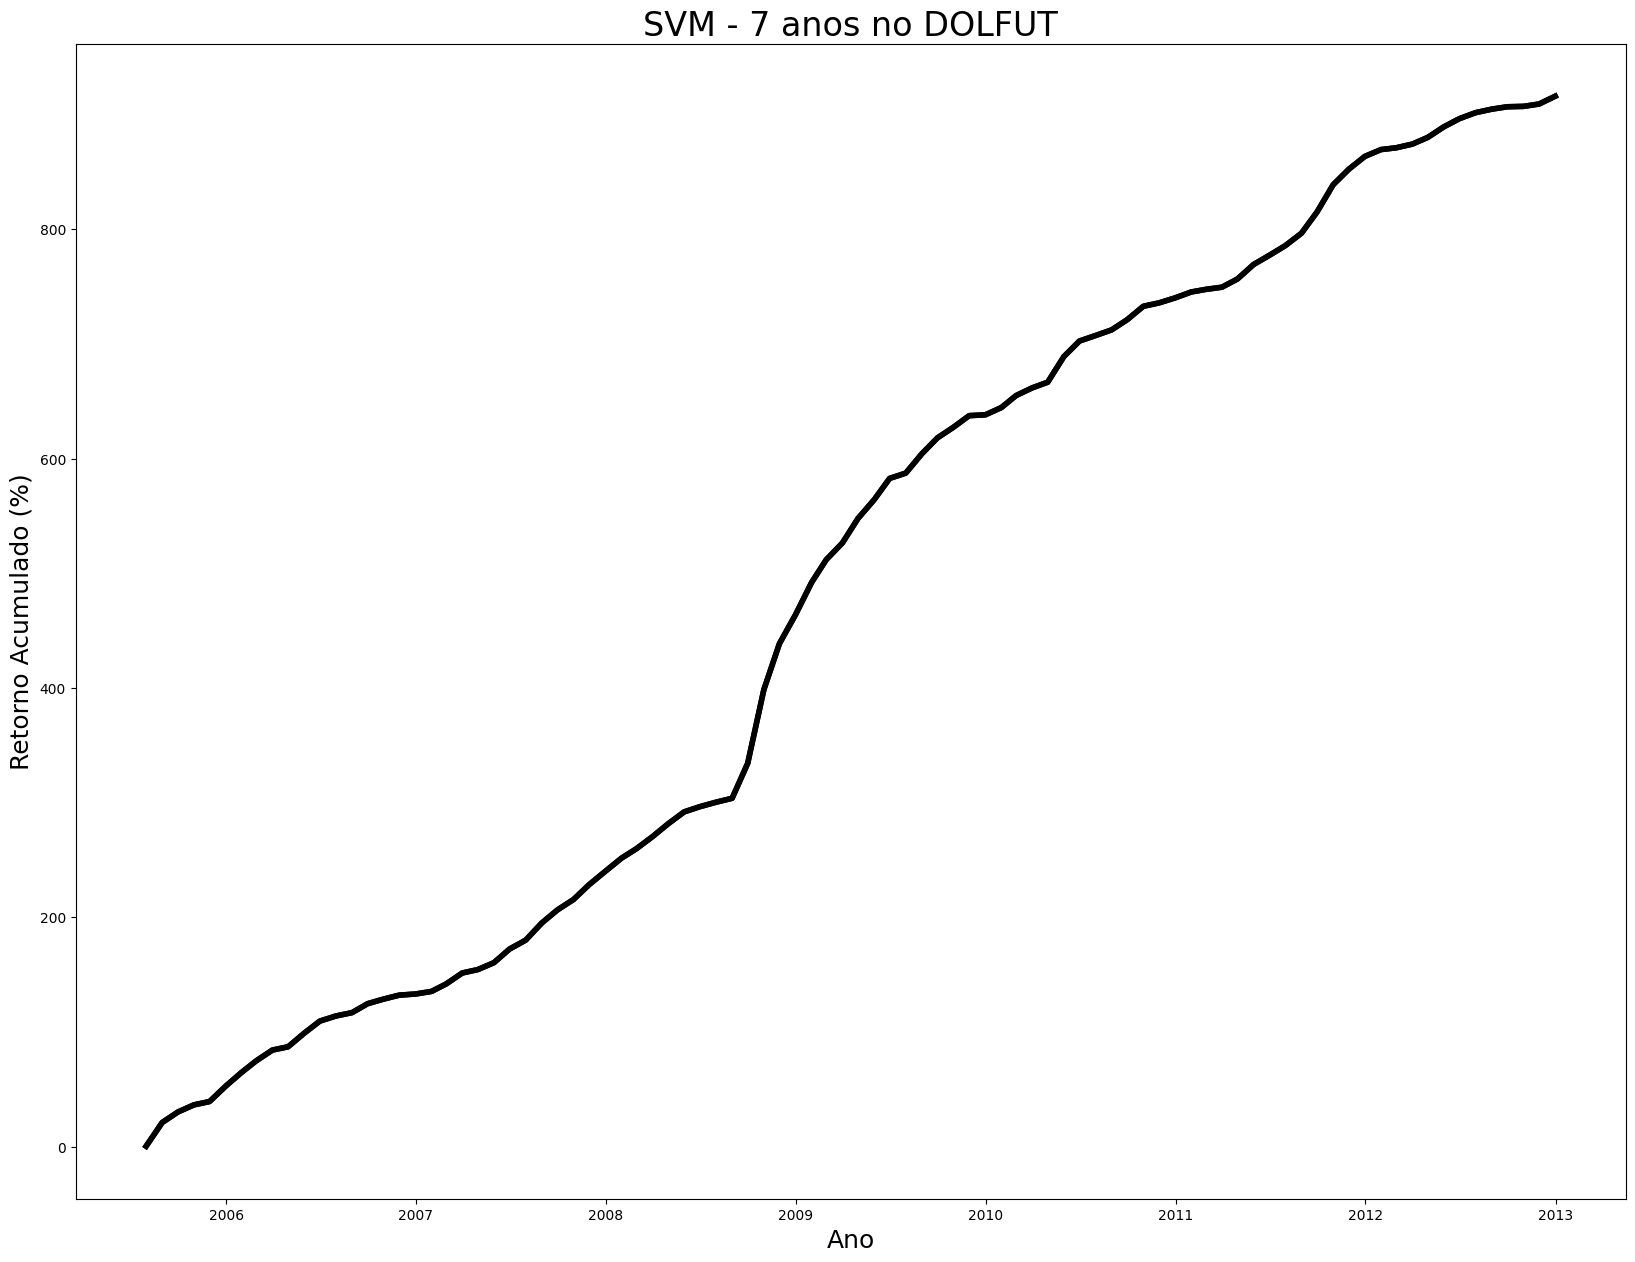

In [48]:
# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("SVM - 7 anos no DOLFUT", fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text("2009-08-01", 500, "Treinamento: 2005-2012", **setup)
    plt.text("2014-01-01", 500, "Teste: 2013-2020", **setup)
    plt.text("2010-01-01", 465, "Retorno total: +980%", **setup2)
    plt.text("2010-01-01", 430, "Retorno teste: +68%", **setup2)
    plt.text("2014-03-01", 457.5, "www.outspokenmarket.com", **setup2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)


In [49]:
# Calculando a performance - para a base de teste

df1_test1.loc[: , "Previsto"] = y_pred_test1
df1_test1.loc[: , "Retorno_Modelo"] = df1_test1.loc[: , "Previsto"]*df1_test1["Alvo1"]

#Simulando um stop
df1_test1.loc[: , "Retorno_Modelo"] = np.where(df1_test1.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_test1.loc[: , 'Retorno_Modelo'])

df1_test1.loc[: , "Retorno_Modelo_Acumulado"] = df1_test1["Retorno_Modelo"].cumsum()

In [50]:
df1_test1.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-12-02    0.885358
2020-12-03    0.884291
2020-12-04    0.895824
2020-12-07    0.899844
2020-12-08    0.889590
Name: Retorno_Modelo_Acumulado, dtype: float64

In [51]:
df1_test1.index.name = "Date"
df1_test1.reset_index(inplace = True)

df1_test1["Date"] = pd.to_datetime(df1_test1["Date"])

teste_agregado = df1_test1.resample("M", on = "Date").sum()

teste_agregado.loc[: , "Retorno_Modelo_Acumulado"] = teste_agregado["Retorno_Modelo"].cumsum()*100

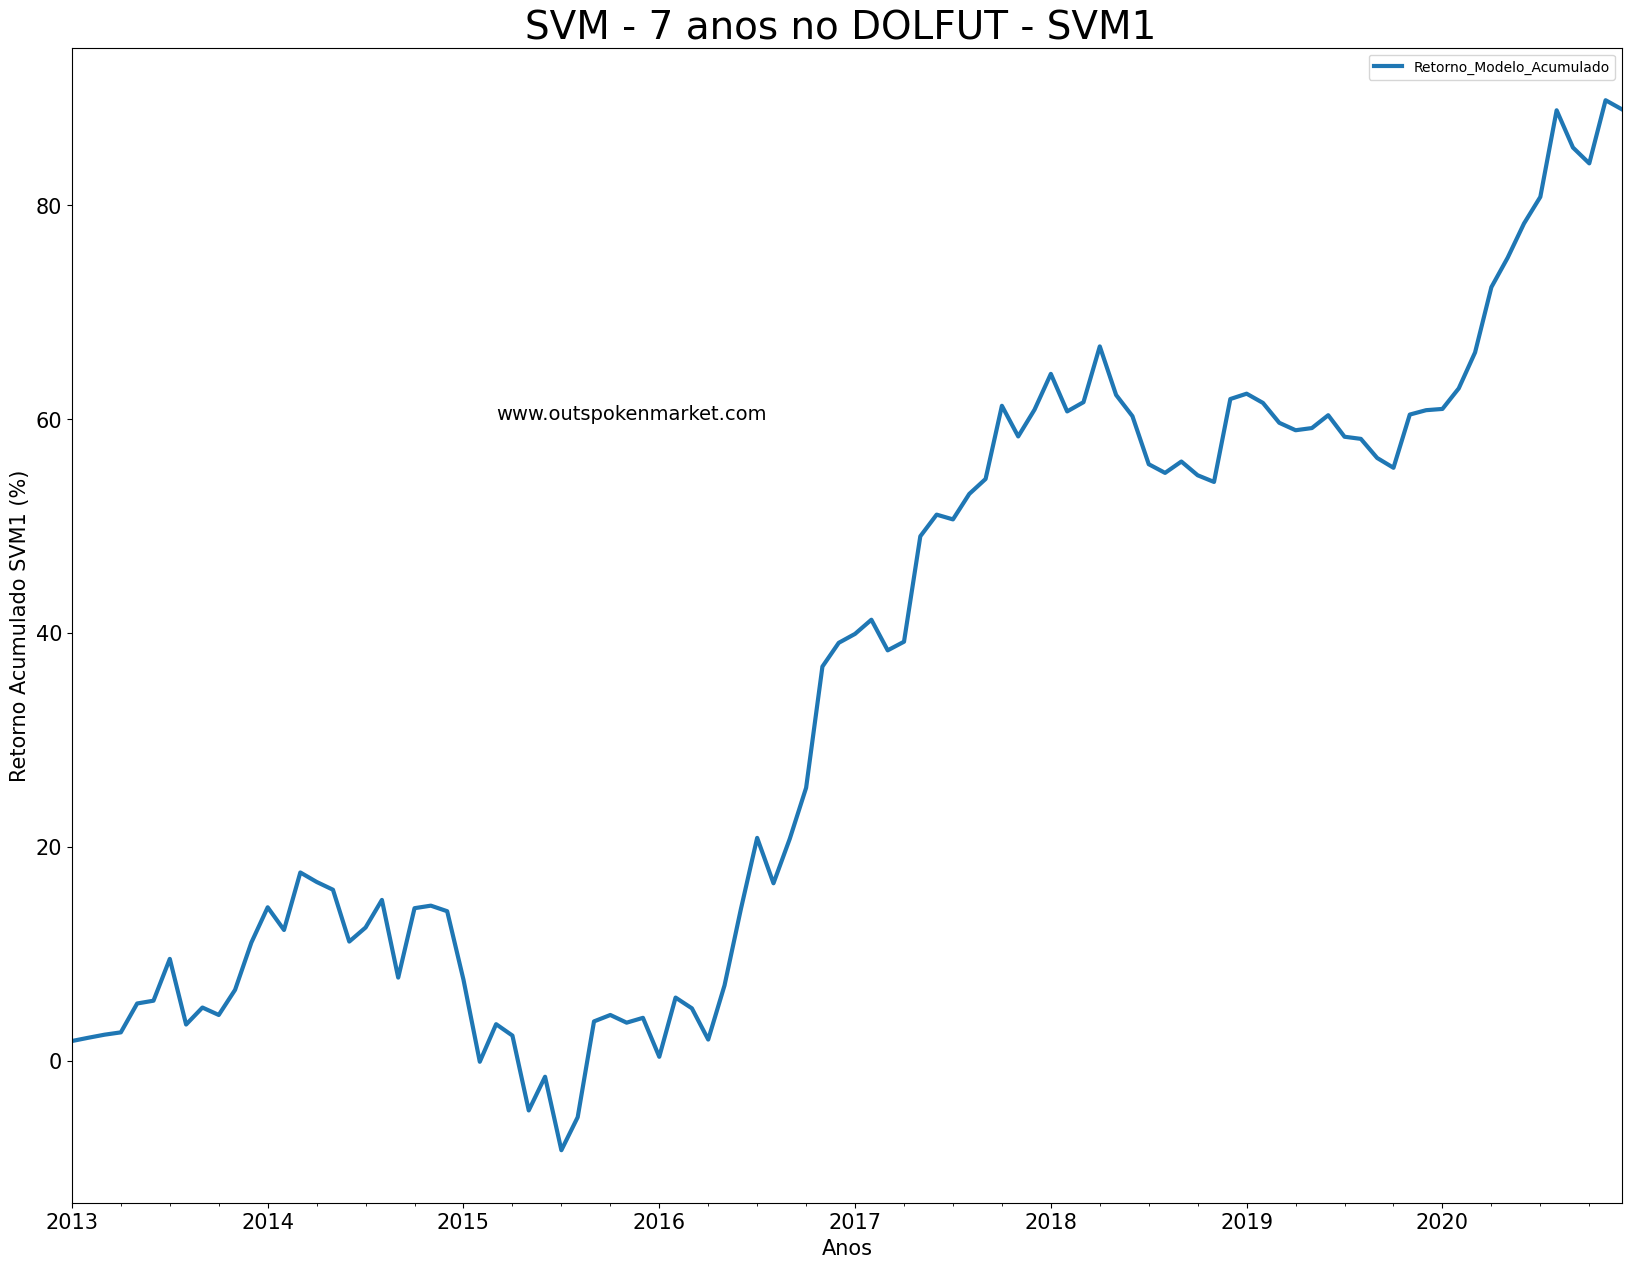

In [52]:
teste_agregado["Retorno_Modelo_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15)
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Retorno Acumulado SVM1 (%)"
           , fontsize = 15);
plt.title("SVM - 7 anos no DOLFUT - SVM1 ", fontsize = 28)
setup2 = dict(size = 14, color = "black")
plt.text("2015-03-01", 60, "www.outspokenmarket.com", **setup2)
plt.legend()
plt.show()

______________________________________________________

### Passo 8 - Otimizaçao com Grid Search

In [53]:
svm2 = svm.SVC(kernel = "rbf")

#C = 1, kernel = "rbf", max_iter = 2000, gamma = "auto", random_state = 42

parametros = {
    "C": np.arange(1, 11, 1), 
    "max_iter" : np.arange(100, 2100, 100),
    "gamma": np.arange(0.01, 1.1, 0.1)
}

In [54]:
scorers = {
    "accuracy_score": make_scorer(accuracy_score)
}

In [55]:
def otimizacao(refit_score = "accuracy_score"):
    
    inicio = time.time()

    cv = StratifiedKFold(n_splits = 10)
    grid_search = GridSearchCV(svm2, parametros, scoring=scorers, refit = refit_score,
                           cv = cv, return_train_score = True)
    grid_search.fit(x_train1, y_train1)

    # Prediçao na base de teste
    y_pred_train = grid_search.predict(x_train1)
    y_pred_test = grid_search.predict(x_test1)

    print("Melhores parametros para o {}".format(refit_score))
    print(grid_search.best_params_)

    # Matriz de confusao na base de treinamento
    print("\nMatriz de confusao da SVM para {} na base de treinamento:".format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_train1, y_pred_train),
                 columns = ["pred_vende", "pred_nada", "pred_compra"], index=["vende", "nada", "compra"]))
    
    # Matriz de confusao na base de teste
    print("\nMatriz de confusao da SVM para {} na base de treinamento:".format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test1, y_pred_test),
                 columns = ["pred_vende", "pred_nada", "pred_compra"], index=["vende", "nada", "compra"]))
    print("Tempo de execuçao: %s minutos" % str(((time.time() - inicio))/60))
    return grid_search

In [ ]:
#Best params for accuracy_score
#{'C': 2, 'gamma': 0.01, 'max_iter': 900}

In [ ]:
#otimizacao_svm = otimizacao(refit_score = "accuracy_score")

In [ ]:
#otimizacao_svm

______________________________________________________

### Passo 9 - Treinamento com o modelo otimizado

In [56]:
# Treinando o modelo

df1_train3 = df1_filtrado3.loc[start_train : end_train]

df1_test3 = df1_filtrado3.loc[start_test : end_test]

# Kernels: rbf, poly, linear

svm3 = svm.SVC(kernel = "rbf", C = 2, gamma = 0.01, max_iter = 2000, random_state = 42)

svm3.fit(x_train1, y_train1)# essa é a linha que treina o modelo!!!!

SVC(C=2, gamma=0.01, max_iter=2000, random_state=42)

In [57]:
# Prediçoes para o treinamento e teste

y_pred_train3 = svm3.predict(x_train1)
y_pred_test3 = svm3.predict(x_test1)

In [58]:
# Treinamento

print(confusion_matrix(y_train1, y_pred_train3))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train1, y_pred_train3))

[[413 167  99]
 [199 276  73]
 [240 153 206]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.48      0.61      0.54       679
           0       0.46      0.50      0.48       548
           1       0.54      0.34      0.42       599

    accuracy                           0.49      1826
   macro avg       0.50      0.49      0.48      1826
weighted avg       0.50      0.49      0.48      1826



In [59]:
# Teste

print(confusion_matrix(y_test1, y_pred_test3))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test3))

[[367 191 155]
 [249 152  86]
 [368 225 172]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.37      0.51      0.43       713
           0       0.27      0.31      0.29       487
           1       0.42      0.22      0.29       765

    accuracy                           0.35      1965
   macro avg       0.35      0.35      0.34      1965
weighted avg       0.36      0.35      0.34      1965



In [60]:
# Calculando a performance - para toda a base

y_pred_all3 = svm3.predict(df1_filtrado3.iloc[:, 9:24])

In [61]:
df1_filtrado3.loc[: , "Previsto"] = y_pred_all3
df1_filtrado3.loc[: , "Retorno_Modelo"] = df1_filtrado3.loc[: , "Previsto"]*df1_filtrado3["Alvo1"]

#Simulando um stop
df1_filtrado3.loc[: , "Retorno_Modelo"] = np.where(df1_filtrado3.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_filtrado3.loc[: , 'Retorno_Modelo'])

df1_filtrado3.loc[: , "Retorno_Modelo_Acumulado"] = df1_filtrado3["Retorno_Modelo"].cumsum()

In [62]:
df1_filtrado3.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-12-08    3.994655
2020-12-09    4.022688
2020-12-10    4.031241
2020-12-11    4.021972
2020-12-14    4.027443
Name: Retorno_Modelo_Acumulado, dtype: float64

In [63]:
# Para fazer um conditional plot

df1_filtrado3.index.name = "Date"
df1_filtrado3.reset_index(inplace = True)

df1_filtrado3["Date"] = pd.to_datetime(df1_filtrado3["Date"])

df1_filtrado3["train_test"] = np.where(df1_filtrado3["Date"] > end_train, 1, -1)

In [64]:
df1_filtrado3.head()

,Date,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,...,f,T,w,k,tau,g,Previsto,Retorno_Modelo,Retorno_Modelo_Acumulado,train_test
0,2005-07-04,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,...,6,7,6,0,3,2,-1,-0.005017,-0.005017,-1
1,2005-07-05,2400.0,2404.0,2384.0,2404.0,2415.0,0.005017,0.004576,11.0,1,...,5,7,5,4,6,5,-1,-0.004576,-0.009592,-1
2,2005-07-06,2406.0,2422.0,2406.0,2415.0,2396.0,0.004576,-0.007867,-19.0,-1,...,8,8,8,7,8,7,-1,0.007867,-0.001725,-1
3,2005-07-07,2426.0,2427.0,2396.0,2396.0,2388.0,-0.007867,-0.003339,-8.0,-1,...,7,6,7,7,8,6,1,-0.003339,-0.005064,-1
4,2005-07-08,2406.0,2406.0,2379.0,2388.0,2359.0,-0.003339,-0.012144,-29.0,-1,...,1,7,1,4,2,3,-1,0.012144,0.007080,-1


In [65]:
base_agregada3 = df1_filtrado3.resample("M", on = "Date").sum()

base_agregada3.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada3["Retorno_Modelo"].cumsum()*100

ConversionError: Failed to convert value(s) to axis units: '2012-12-31'

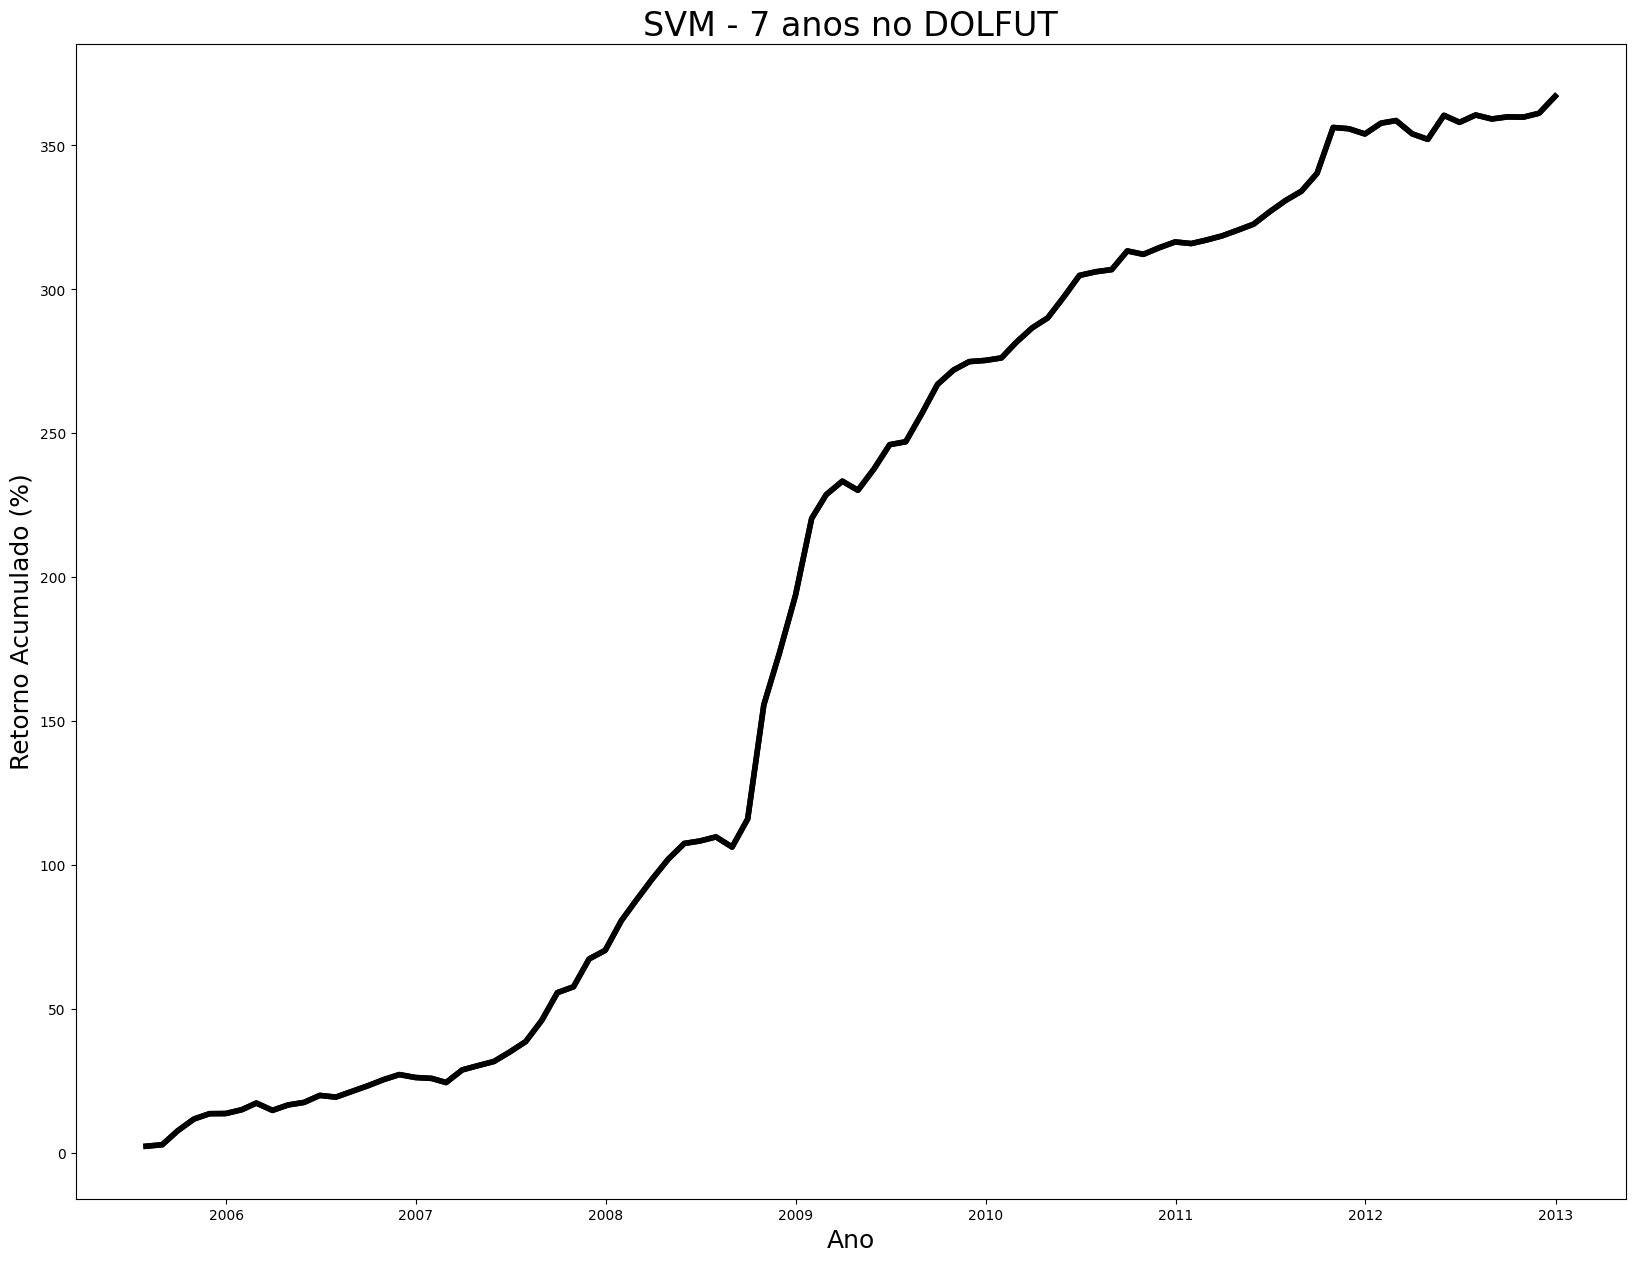

In [66]:
# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("SVM - 7 anos no DOLFUT", fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text("2009-09-01", 200, "Treinamento: 2005-2012", **setup)
    plt.text("2014-01-01", 200, "Teste: 2013-2020", **setup)
    plt.text("2009-09-01", 165, "Retorno total: +389.9%", **setup2)
    plt.text("2009-09-01", 150, "Retorno teste: +25.6%", **setup2)
    plt.text("2014-03-01", 157.5, "www.outspokenmarket.com", **setup2)

base_agregada3.groupby((base_agregada3["train_test"].shift() * base_agregada3["train_test"] < 0).cumsum()).apply(grafico)


In [67]:
# Calculando a performance - para a base de teste

df1_test3.loc[: , "Previsto"] = y_pred_test3
df1_test3.loc[: , "Retorno_Modelo"] = df1_test3.loc[: , "Previsto"]*df1_test3["Alvo1"]

#Simulando um stop
df1_test3.loc[: , "Retorno_Modelo"] = np.where(df1_test3.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_test3.loc[: , 'Retorno_Modelo'])

df1_test3.loc[: , "Retorno_Modelo_Acumulado"] = df1_test3["Retorno_Modelo"].cumsum()

In [68]:
df1_test3.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-12-02    0.340221
2020-12-03    0.341288
2020-12-04    0.329755
2020-12-07    0.333775
2020-12-08    0.323521
Name: Retorno_Modelo_Acumulado, dtype: float64

In [69]:
df1_test3.index.name = "Date"
df1_test3.reset_index(inplace = True)

df1_test3["Date"] = pd.to_datetime(df1_test3["Date"])

teste_agregado3 = df1_test3.resample("M", on = "Date").sum()

teste_agregado3.loc[: , "Retorno_Modelo_Acumulado"] = teste_agregado3["Retorno_Modelo"].cumsum()*100

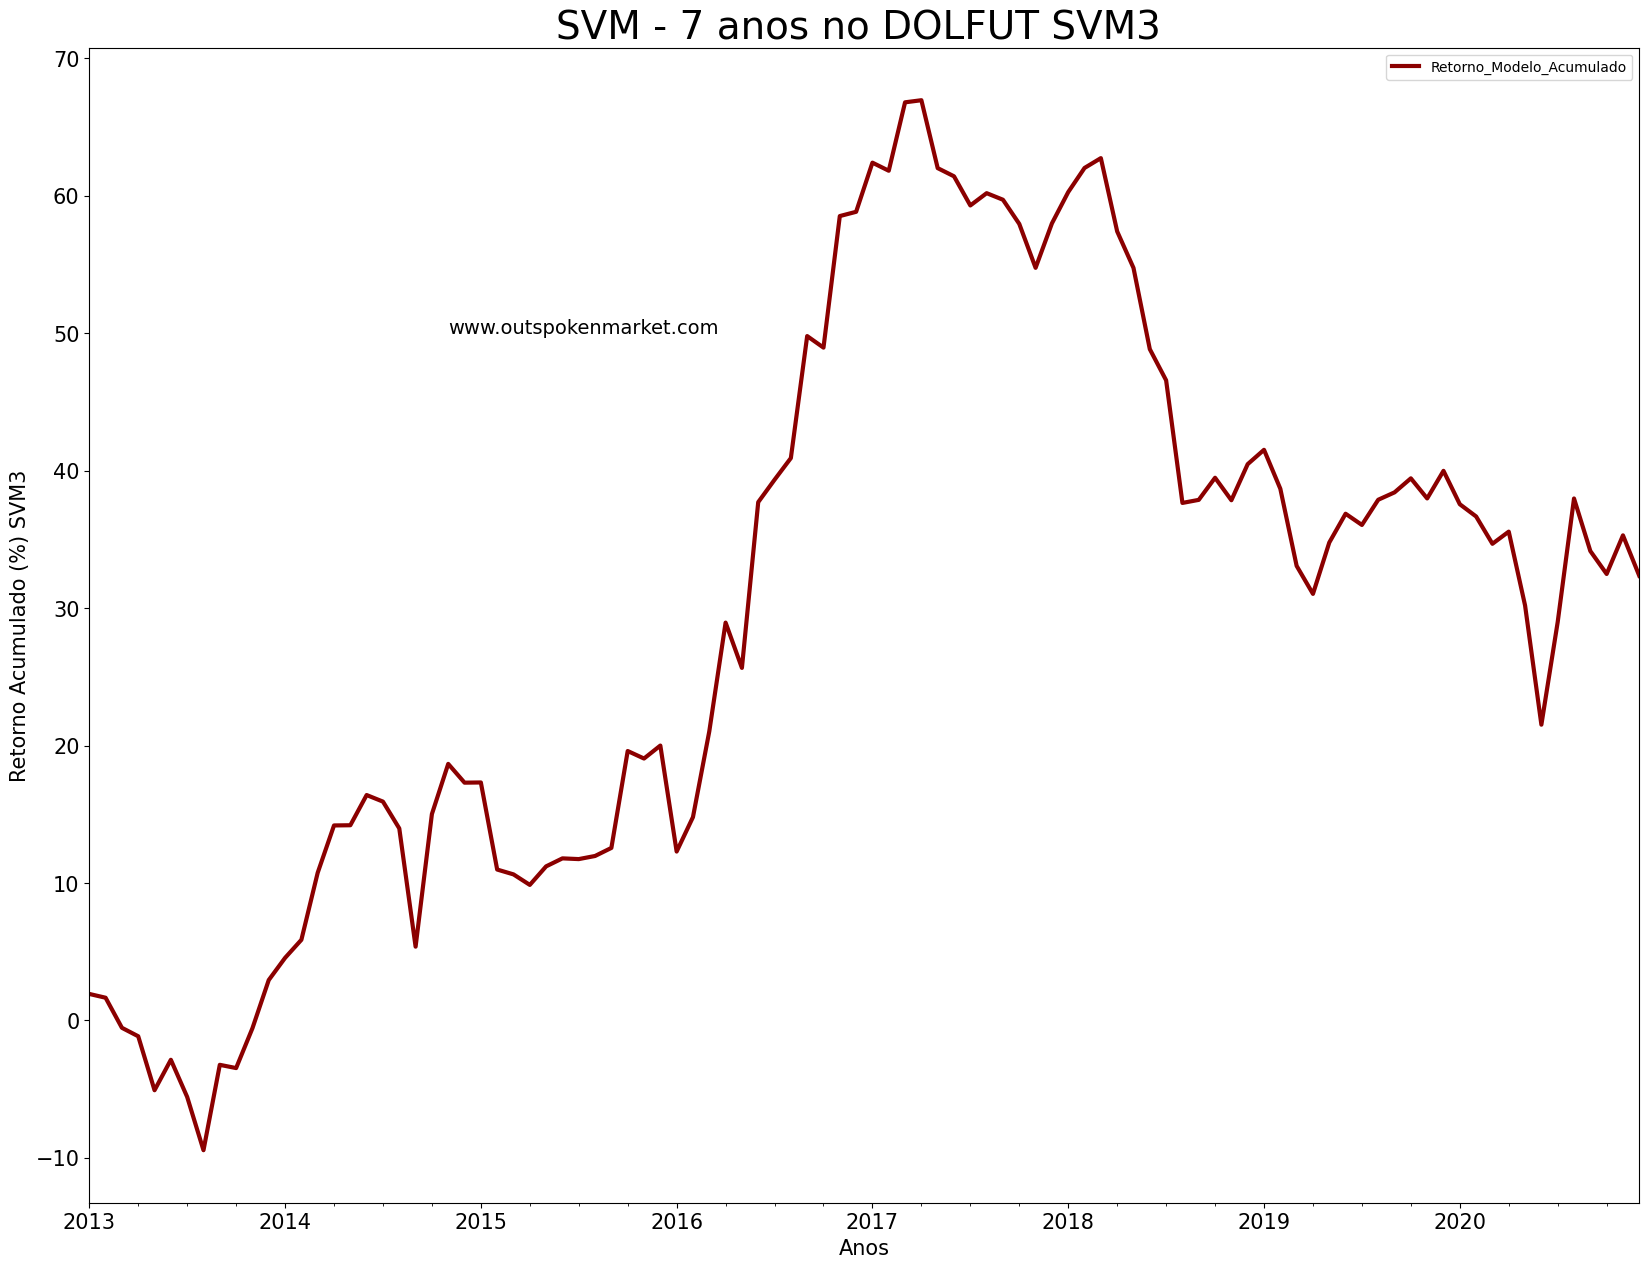

In [70]:
teste_agregado3["Retorno_Modelo_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15
                                     , color = "darkred")
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Retorno Acumulado (%) SVM3"
           , fontsize = 15);
plt.title("SVM - 7 anos no DOLFUT SVM3 ", fontsize = 28)
setup2 = dict(size = 14, color = "black")
plt.text("2014-11-01", 50, "www.outspokenmarket.com", **setup2)
plt.legend()
plt.show()

In [ ]:
# O modelo otimizado "corrigiu" 2014 e 2015, melhorou 2016, porém deteriorou 2018-2020

______________________________________________________

### Passo 10 - Ensemble simples

In [71]:
# Treinando o modelo

df1_train4 = df1_filtrado4.loc[start_train : end_train]

df1_test4 = df1_filtrado4.loc[start_test : end_test]

In [72]:
# Prediçoes para o treinamento e teste

prop = 0.5
prop_c = 1-prop

y_pred_train4 = (y_pred_train1*prop + y_pred_train3*prop_c)
y_pred_test4 = (y_pred_test1*prop + y_pred_test3*prop_c)

In [ ]:
y_pred_train4

In [73]:
y_pred_train4 = np.where(y_pred_train4 >= 0.5, 1, y_pred_train4)
y_pred_train4 = np.where(y_pred_train4 < -0.5, -1, y_pred_train4)
y_pred_train4 = np.where(((y_pred_train4 != -1) & (y_pred_train4 != 1)), 0, y_pred_train4)

y_pred_test4 = np.where(y_pred_test4 >= 0.5, 1, y_pred_test4)
y_pred_test4 = np.where(y_pred_test4 < -0.5, -1, y_pred_test4)
y_pred_test4 = np.where(((y_pred_test4 != -1) & (y_pred_test4 != 1)), 0, y_pred_test4)

In [74]:
# Treinamento

print(confusion_matrix(y_train1, y_pred_train4))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_train1, y_pred_train4))

[[400 243  36]
 [100 378  70]
 [ 96 220 283]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.67      0.59      0.63       679
           0       0.45      0.69      0.54       548
           1       0.73      0.47      0.57       599

    accuracy                           0.58      1826
   macro avg       0.62      0.58      0.58      1826
weighted avg       0.62      0.58      0.58      1826



In [75]:
# Teste

print(confusion_matrix(y_test1, y_pred_test4))
print()
print("--------------------------------------------------------------------------------")
print()
print(classification_report(y_test1, y_pred_test4))

[[276 307 130]
 [175 230  82]
 [264 321 180]]

--------------------------------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.39      0.39      0.39       713
           0       0.27      0.47      0.34       487
           1       0.46      0.24      0.31       765

    accuracy                           0.35      1965
   macro avg       0.37      0.36      0.35      1965
weighted avg       0.39      0.35      0.35      1965



In [76]:
# Calculando a performance - para toda a base

y_pred_all4 = (y_pred_all*prop + y_pred_all3*prop_c)
y_pred_all4 = np.where(y_pred_all4 >= 0.5, 1, y_pred_all4)
y_pred_all4 = np.where(y_pred_all4 < -0.5, -1, y_pred_all4)
y_pred_all4 = np.where(((y_pred_all4 != -1) & (y_pred_all4 != 1)), 0, y_pred_all4)

In [77]:
df1_filtrado4.loc[: , "Previsto"] = y_pred_all4
df1_filtrado4.loc[: , "Retorno_Modelo"] = df1_filtrado4.loc[: , "Previsto"]*df1_filtrado4["Alvo1"]

#Simulando um stop
df1_filtrado4.loc[: , "Retorno_Modelo"] = np.where(df1_filtrado4.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_filtrado4.loc[: , 'Retorno_Modelo'])

df1_filtrado4.loc[: , "Retorno_Modelo_Acumulado"] = df1_filtrado4["Retorno_Modelo"].cumsum()

In [78]:
df1_filtrado4.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-12-08    7.141685
2020-12-09    7.169718
2020-12-10    7.178271
2020-12-11    7.178271
2020-12-14    7.183742
Name: Retorno_Modelo_Acumulado, dtype: float64

In [79]:
# Para fazer um conditional plot

df1_filtrado4.index.name = "Date"
df1_filtrado4.reset_index(inplace = True)

df1_filtrado4["Date"] = pd.to_datetime(df1_filtrado4["Date"])

df1_filtrado4["train_test"] = np.where(df1_filtrado4["Date"] > end_train, 1, -1)

In [80]:
df1_filtrado4.head()

,Date,Abertura,Maxima,Minima,Fechamento,Lag1,Retorno,Alvo1,Pontos,Alvo_Bin,...,f,T,w,k,tau,g,Previsto,Retorno_Modelo,Retorno_Modelo_Acumulado,train_test
0,2005-07-04,2400.0,2403.0,2392.0,2392.0,2404.0,0.008857,0.005017,12.0,1,...,6,7,6,0,3,2,-1.0,-0.005017,-0.005017,-1
1,2005-07-05,2400.0,2404.0,2384.0,2404.0,2415.0,0.005017,0.004576,11.0,1,...,5,7,5,4,6,5,0.0,0.000000,-0.005017,-1
2,2005-07-06,2406.0,2422.0,2406.0,2415.0,2396.0,0.004576,-0.007867,-19.0,-1,...,8,8,8,7,8,7,-1.0,0.007867,0.002851,-1
3,2005-07-07,2426.0,2427.0,2396.0,2396.0,2388.0,-0.007867,-0.003339,-8.0,-1,...,7,6,7,7,8,6,0.0,-0.000000,0.002851,-1
4,2005-07-08,2406.0,2406.0,2379.0,2388.0,2359.0,-0.003339,-0.012144,-29.0,-1,...,1,7,1,4,2,3,-1.0,0.012144,0.014995,-1


In [81]:
base_agregada4 = df1_filtrado4.resample("M", on = "Date").sum()

base_agregada4.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada4["Retorno_Modelo"].cumsum()*100

ConversionError: Failed to convert value(s) to axis units: '2012-12-31'

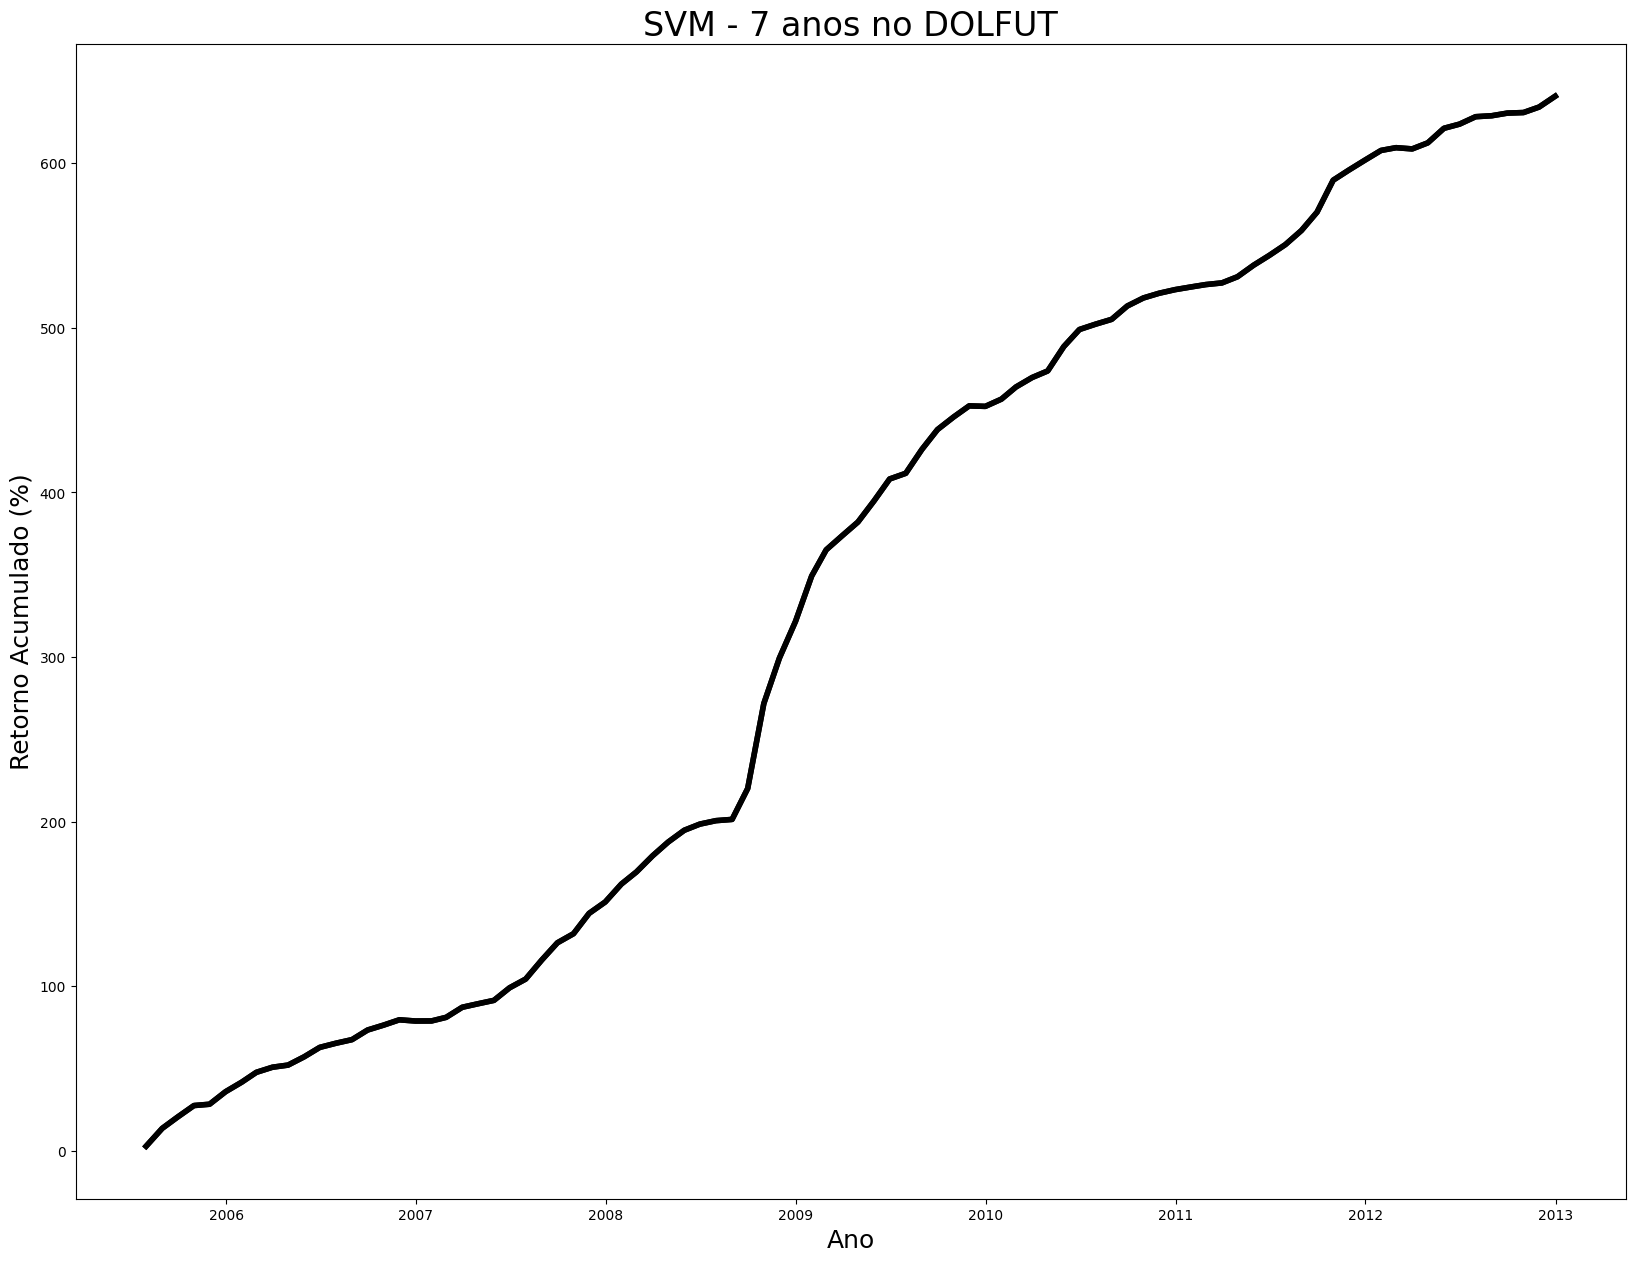

In [82]:
# Plota o grafico
fig, ax = plt.subplots(figsize = (20,15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("SVM - 7 anos no DOLFUT", fontsize = 24)
    plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)
    setup = dict(size = 16, color = "darkgreen")
    setup2 = dict(size = 14, color = "black")
    plt.text("2009-09-01", 300, "Treinamento: 2005-2012", **setup)
    plt.text("2014-01-01", 300, "Teste: 2013-2020", **setup)
    plt.text("2009-09-01", 265, "Retorno total: +706%", **setup2)
    plt.text("2009-09-01", 250, "Retorno teste: +67%", **setup2)
    plt.text("2014-03-01", 257.5, "www.outspokenmarket.com", **setup2)

base_agregada4.groupby((base_agregada4["train_test"].shift() * base_agregada4["train_test"] < 0).cumsum()).apply(grafico)


In [83]:
# Calculando a performance - para a base de teste

df1_test4.loc[: , "Previsto"] = y_pred_test4
df1_test4.loc[: , "Retorno_Modelo"] = df1_test4.loc[: , "Previsto"]*df1_test4["Alvo1"]

#Simulando um stop
df1_test4.loc[: , "Retorno_Modelo"] = np.where(df1_test4.loc[: , 'Retorno_Modelo'] < -stop
                                               , -stop, df1_test4.loc[: , 'Retorno_Modelo'])

df1_test4.loc[: , "Retorno_Modelo_Acumulado"] = df1_test4["Retorno_Modelo"].cumsum()

In [84]:
df1_test4.loc[: , "Retorno_Modelo_Acumulado"].tail()

Data
2020-12-02    0.741214
2020-12-03    0.741214
2020-12-04    0.741214
2020-12-07    0.745234
2020-12-08    0.734980
Name: Retorno_Modelo_Acumulado, dtype: float64

In [85]:
df1_test4.index.name = "Date"
df1_test4.reset_index(inplace = True)

df1_test4["Date"] = pd.to_datetime(df1_test4["Date"])

teste_agregado4 = df1_test4.resample("M", on = "Date").sum()

teste_agregado4.loc[: , "Retorno_Modelo_Acumulado"] = teste_agregado4["Retorno_Modelo"].cumsum()*100

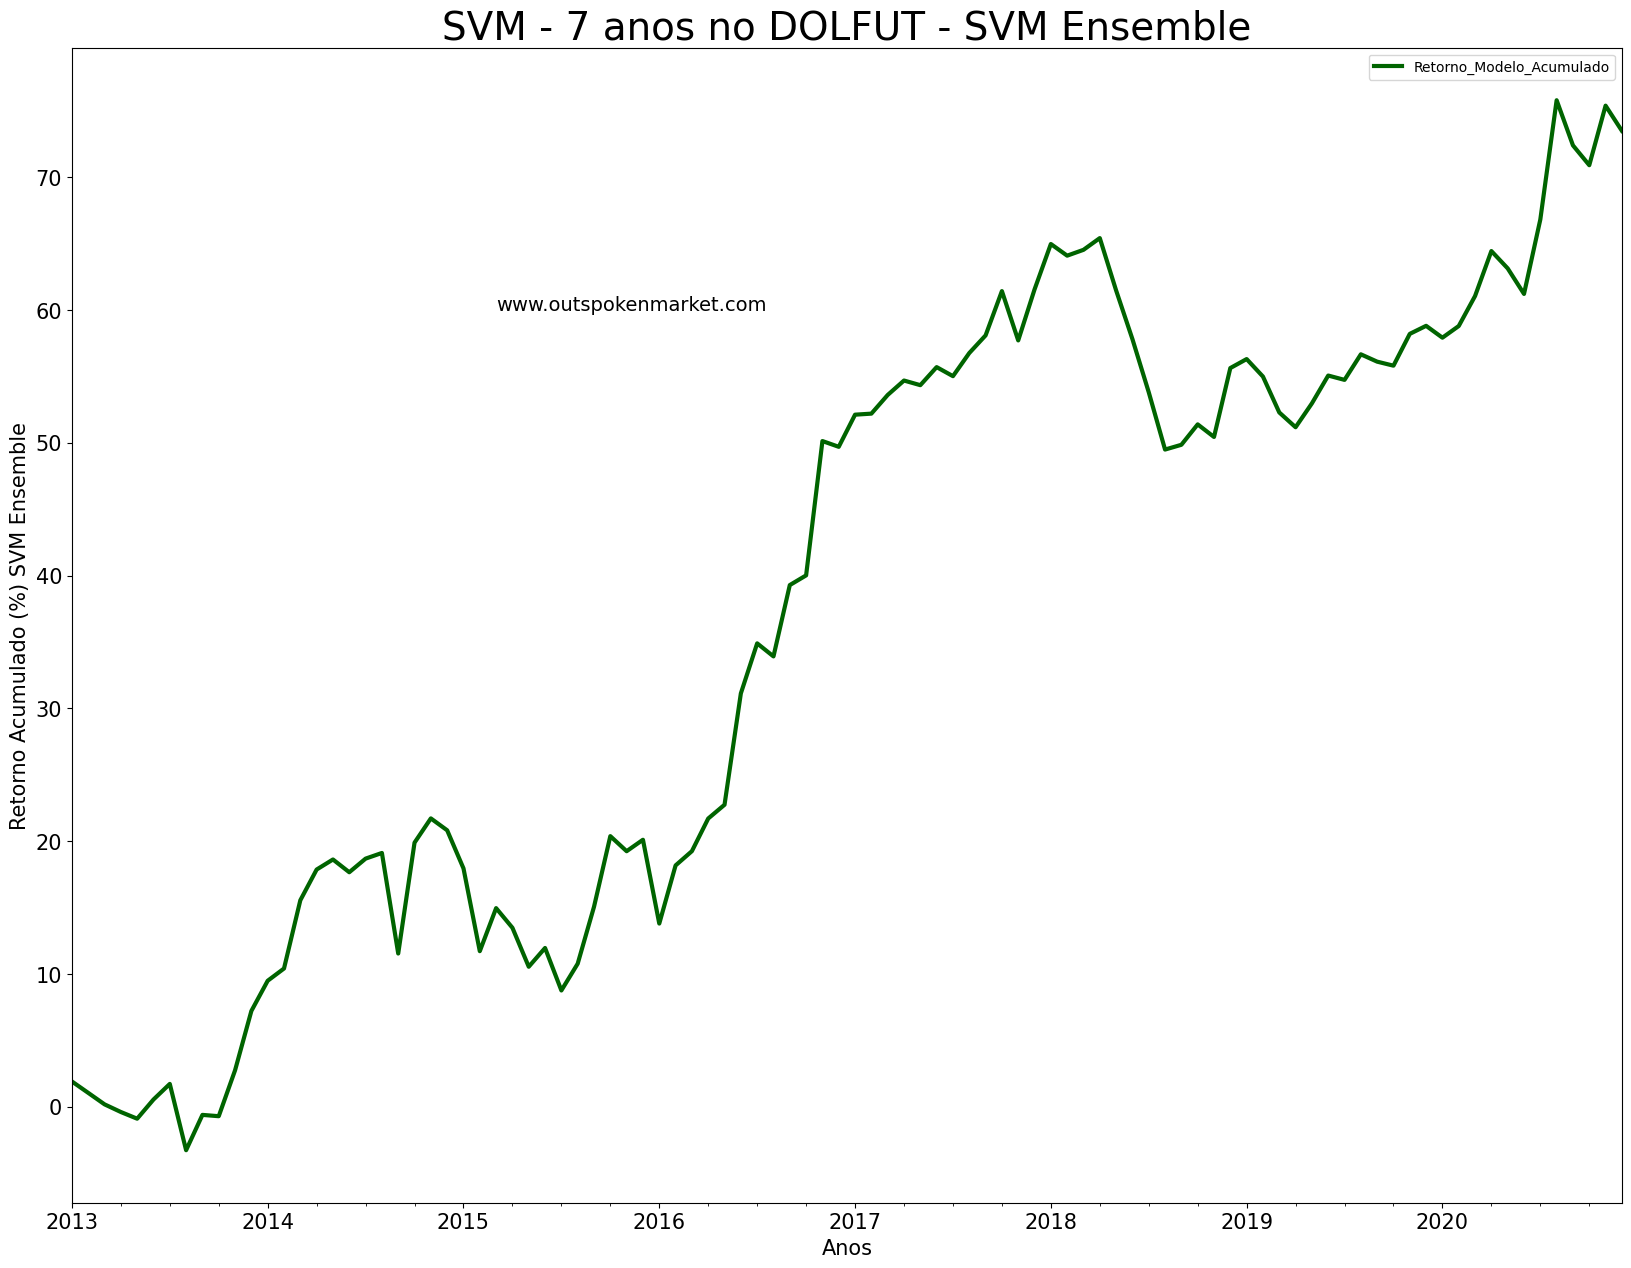

In [86]:
teste_agregado4["Retorno_Modelo_Acumulado"].plot(figsize=(20,15)
                                     , linewidth = 3
                                     , fontsize = 15
                                     , color = "darkgreen")
plt.xlabel("Anos"
           , fontsize = 15);
plt.ylabel("Retorno Acumulado (%) SVM Ensemble"
           , fontsize = 15);
plt.title("SVM - 7 anos no DOLFUT - SVM Ensemble", fontsize = 28)
setup2 = dict(size = 14, color = "black")
plt.text("2015-03-01", 60, "www.outspokenmarket.com", **setup2)
plt.legend()
plt.show()

In [ ]:
# Reduzimos muito o drawdown de 2015 e de 2020 do SVM1 e SVM3